In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.datasets.mnist import FashionMNIST
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class FashionMNISTPairs(Dataset):
    def __init__(self, dataset: FashionMNIST, num_pairs_per_epoch=100000):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3), # Convert 1 channel to 3 channels
            transforms.Resize((224, 224)), # Resize to the size expected by ResNet18
            transforms.ToTensor()
        ])
        self.length = len(dataset)
        self.num_pairs_per_epoch = num_pairs_per_epoch
        self.pairs_indices = self.generate_pairs_indices()

    def generate_pairs_indices(self):
        pairs_indices = []
        for _ in range(self.num_pairs_per_epoch):
            i, j = random.sample(range(self.length), 2)
            pairs_indices.append((i, j))
        return pairs_indices


    def __len__(self):
        return self.num_pairs_per_epoch

    def __getitem__(self, idx):
        i, j = self.pairs_indices[idx]
        img1, label1 = self.dataset[i]
        img2, label2 = self.dataset[j]
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return img1, img2, torch.tensor(label1), torch.tensor(label2)

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super(SiameseNetwork, self).__init__()
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc_embedding = nn.Linear(512, 128)  # Embedding layer for Siamese Network
        self.fc_classifier = nn.Linear(128, num_classes)  # Classifier layer

    def forward(self, input1, input2):
        # Feature extraction
        feat1 = self.feature_extractor(input1)
        feat2 = self.feature_extractor(input2)

        # Flatten feature maps
        feat1 = feat1.view(feat1.size(0), -1)
        feat2 = feat2.view(feat2.size(0), -1)

        # Embedding
        emb1 = self.fc_embedding(feat1)
        emb2 = self.fc_embedding(feat2)

        # Classification
        class1 = self.fc_classifier(emb1)
        class2 = self.fc_classifier(emb2)

        return emb1, emb2, class1, class2

    def extract_features(self, input):
        with torch.no_grad():
            features = self.feature_extractor(input)
            features = features.view(features.size(0), -1)
            features = self.fc_embedding(features)
        return features

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [5]:
from tqdm import tqdm

class Trainer:
    def __init__(self, model, contrastive_criterion, classifier_criterion, optimizer, dataloader, device):
        self.model = model
        self.contrastive_criterion = contrastive_criterion
        self.classifier_criterion = classifier_criterion
        self.optimizer = optimizer
        self.dataloader = dataloader
        self.device = device
        self.epoch_losses = []

    def train(self, num_epochs):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            progress_bar = tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for img1, img2, label1, label2 in progress_bar:
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                self.optimizer.zero_grad()
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                # Calculate same_label dynamically
                same_label = (label1 == label2).float()
                
                # Calculate losses
                contrastive_loss = self.contrastive_criterion(emb1, emb2, same_label)
                classifier_loss1 = self.classifier_criterion(class1, label1)
                classifier_loss2 = self.classifier_criterion(class2, label2)
                total_loss = contrastive_loss + classifier_loss1 + classifier_loss2
                
                total_loss.backward()
                self.optimizer.step()
                
                epoch_loss += total_loss.item()
                progress_bar.set_postfix(loss=total_loss.item())
            avg_epoch_loss = epoch_loss / len(self.dataloader)
            self.epoch_losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}")

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.epoch_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.show()


In [9]:
class EmbeddingVisualizer:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def extract_embeddings(self):
        self.model.to(self.device)
        self.model.eval()
        embeddings = []
        labels = []
        
        with torch.no_grad():
            for img1, img2, label1, label2 in tqdm(self.dataloader, desc="Extracting Embeddings"):
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                emb1, emb2, _, _ = self.model(img1, img2)
                
                embeddings.append(emb1.cpu().numpy())
                embeddings.append(emb2.cpu().numpy())
                labels.append(label1.cpu().numpy())
                labels.append(label2.cpu().numpy())

        embeddings = np.concatenate(embeddings, axis=0)
        labels = np.concatenate(labels, axis=0)
        return embeddings, labels

    def visualize(self, embeddings, labels):
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(embeddings)
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5)
        plt.colorbar(scatter, ticks=range(10))
        plt.title('t-SNE visualization of image embeddings')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

In [7]:
class Tester:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def test(self):
        self.model.to(self.device)
        self.model.eval()
        all_labels = []
        all_predictions1 = []
        all_predictions2 = []

        with torch.no_grad():
            for img1, img2, label1, label2 in tqdm(self.dataloader, desc="Testing"):
                img1, img2, label1, label2 = img1.to(self.device), img2.to(self.device), label1.to(self.device), label2.to(self.device)
                
                emb1, emb2, class1, class2 = self.model(img1, img2)
                
                _, pred1 = torch.max(class1, 1)
                _, pred2 = torch.max(class2, 1)
                
                all_labels.extend(label1.cpu().numpy())
                all_labels.extend(label2.cpu().numpy())
                all_predictions1.extend(pred1.cpu().numpy())
                all_predictions2.extend(pred2.cpu().numpy())

        all_predictions = np.concatenate([all_predictions1, all_predictions2])
        all_labels = np.array(all_labels)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Test Precision: {precision:.2f}")
        print(f"Test Recall: {recall:.2f}")
        print(f"Test F1 Score: {f1:.2f}")

        return accuracy, precision, recall, f1

using device: cuda
starting training


Epoch 1/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=4.59]


Epoch 1/20, Loss: 5.509878401853601


Epoch 2/20: 100%|██████████| 98/98 [01:31<00:00,  1.08it/s, loss=4.31]


Epoch 2/20, Loss: 4.49322155543736


Epoch 3/20: 100%|██████████| 98/98 [01:30<00:00,  1.09it/s, loss=3.94]


Epoch 3/20, Loss: 4.098360893677692


Epoch 4/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=3.21]


Epoch 4/20, Loss: 3.5102019018056443


Epoch 5/20: 100%|██████████| 98/98 [01:32<00:00,  1.06it/s, loss=2.8] 


Epoch 5/20, Loss: 2.933654254796554


Epoch 6/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=2.3] 


Epoch 6/20, Loss: 2.453559213755082


Epoch 7/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=2.03]


Epoch 7/20, Loss: 2.131627839438769


Epoch 8/20: 100%|██████████| 98/98 [01:31<00:00,  1.08it/s, loss=1.77]


Epoch 8/20, Loss: 1.8808952898395306


Epoch 9/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=1.55]


Epoch 9/20, Loss: 1.678664150286694


Epoch 10/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=1.44]


Epoch 10/20, Loss: 1.514374580918526


Epoch 11/20: 100%|██████████| 98/98 [01:30<00:00,  1.08it/s, loss=1.28]


Epoch 11/20, Loss: 1.3683155203352169


Epoch 12/20: 100%|██████████| 98/98 [01:30<00:00,  1.09it/s, loss=1.26]


Epoch 12/20, Loss: 1.243268212493585


Epoch 13/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=1.08]


Epoch 13/20, Loss: 1.1386748990234064


Epoch 14/20: 100%|██████████| 98/98 [01:30<00:00,  1.08it/s, loss=1.02] 


Epoch 14/20, Loss: 1.0542245178806537


Epoch 15/20: 100%|██████████| 98/98 [01:30<00:00,  1.08it/s, loss=0.995]


Epoch 15/20, Loss: 0.9924064436737372


Epoch 16/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=0.935]


Epoch 16/20, Loss: 0.9438930457952072


Epoch 17/20: 100%|██████████| 98/98 [01:30<00:00,  1.08it/s, loss=0.87] 


Epoch 17/20, Loss: 0.8904748917842398


Epoch 18/20: 100%|██████████| 98/98 [01:31<00:00,  1.08it/s, loss=0.865]


Epoch 18/20, Loss: 0.8696683493195748


Epoch 19/20: 100%|██████████| 98/98 [01:32<00:00,  1.07it/s, loss=0.852]


Epoch 19/20, Loss: 0.824159641655124


Epoch 20/20: 100%|██████████| 98/98 [01:31<00:00,  1.07it/s, loss=0.873]

Epoch 20/20, Loss: 0.8140771693112899


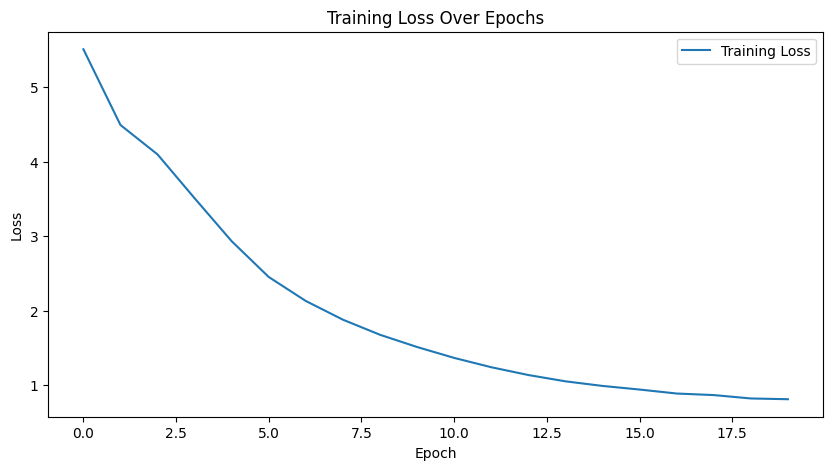

starting testing


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.33it/s]


Test Accuracy: 10.76%
Test Precision: 0.11
Test Recall: 0.11
Test F1 Score: 0.11


ValueError: too many values to unpack (expected 3)

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print('using device:', device)
# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

train_pairs_dataset = FashionMNISTPairs(train_dataset, num_pairs_per_epoch=25000)
test_pairs_dataset = FashionMNISTPairs(test_dataset, num_pairs_per_epoch=2500)

train_loader = DataLoader(train_pairs_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_pairs_dataset, batch_size=8, shuffle=False)

# Initialize model, loss function, and optimizer
model = SiameseNetwork()
contrastive_criterion = ContrastiveLoss()
classifier_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
print('starting training')
trainer = Trainer(model,contrastive_criterion, classifier_criterion, optimizer, train_loader, device)
trainer.train(num_epochs=20)

# Plot the training loss
trainer.plot_losses()

# Test the model
print('starting testing')
tester = Tester(model, test_loader, device)
tester.test()


Extracting Embeddings: 100%|██████████| 313/313 [00:04<00:00, 76.15it/s]


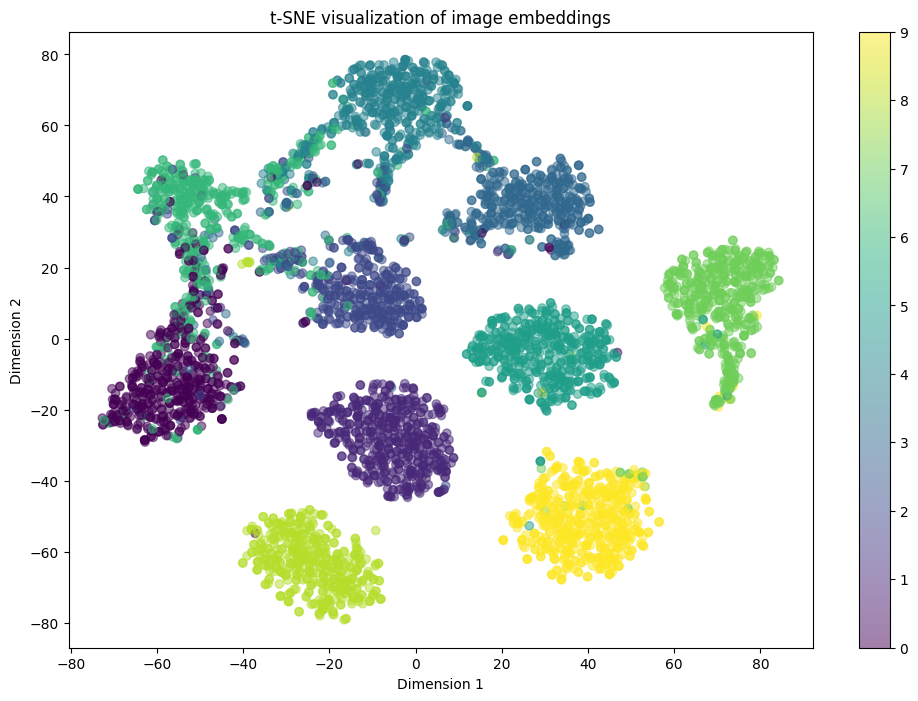

In [10]:

# Visualize embeddings
visualizer = EmbeddingVisualizer(model, test_loader, device)
embeddings, labels = visualizer.extract_embeddings()
visualizer.visualize(embeddings, labels)